In [1]:
import pandas as pd
import numpy as np
import urllib2
import csv
import pylab as pl
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# download city population estimate into database 
# from here: https://www.census.gov/popest/data/metro/totals/2014/index.html
# cut off at 100,000 population
df = pd.read_csv('100cities.csv')

In [3]:
# download list of counties per CSA (caveat that csa's are derived with 2013 population estimates)
df2 = pd.read_csv('CensusCSA.csv', header = 2, usecols = ['CBSA Title', 
                                                          'CSA Code', 
                                                          'Metropolitan/Micropolitan Statistical Area', 
                                                          'CSA Title', "County/County Equivalent", 
                                                          'State Name', "FIPS County Code", 
                                                          "Central/Outlying County"])

In [4]:
# clean up the cities dataset
df['Geography'] = df['Geography'].map(lambda x: x.replace('Metro Area',''))
df['Geography'] = df['Geography'].map(lambda x: x.replace('Micro Area',''))
df['Geography'] = df['Geography'].map(lambda x: x.replace('Metro Division', ''))
df['Geography'] = df['Geography'].map(lambda x: x.rstrip())
df['Geography'] = df['Geography'].map(lambda x: x.lstrip())

In [5]:
df['CBSA Title'] = df['Geography']

In [6]:
csa_counties = pd.merge(df2, df, on='CBSA Title')
# remove puerto rico
csa_counties = csa_counties[csa_counties['State Name'] != 'Puerto Rico']

In [7]:
state_pop = pd.read_csv('county_pop2002.csv')

In [8]:
state_pop.columns

Index([u'Areaname', u'STCOU', u'PST045202D'], dtype='object')

In [9]:
states = state_pop[~state_pop.Areaname.str.contains(',')]

In [10]:
county_pop = pd.read_csv('csa_counties.csv')

In [11]:
mergy = pd.merge(county_pop, state_pop, on = 'STCOU')

In [12]:
energy = pd.read_csv('county_sector.csv', usecols=['State',' County', ' FIPS', ' Total', 'Commercial', 'Industrial','Residential','Electricity Prod','Onroad', 'Cement','Aircraft','Nonroad','Airborne'])

In [13]:
mergy['FIPS'] = mergy['STCOU']
energy['FIPS'] = energy[' FIPS']

In [14]:
city_energy = pd.merge(energy, mergy, on = 'FIPS')

In [15]:
city_energy['per capita'] = city_energy[' Total']*1000000/city_energy['PST045202D']

In [16]:
county_area = pd.read_csv('county_area.csv', usecols = ['USPS', 'FIPS', 'NAME', 'ALAND','ALAND_SQMI'])

In [17]:
# merge to create master file
city_master = pd.merge(city_energy, county_area, on = 'FIPS')

In [18]:
city_master.columns

Index([u'State', u' County', u' FIPS', u' Total', u'Commercial', u'Industrial',
       u'Residential', u'Electricity Prod', u'Onroad', u'Cement', u'Aircraft',
       u'Airborne', u'Nonroad', u'FIPS', u'Unnamed: 0', u'CSA Code',
       u'CBSA Title', u'Metropolitan/Micropolitan Statistical Area',
       u'CSA Title', u'County/County Equivalent', u'State Name',
       u'FIPS County Code', u'State Code', u'STCOU',
       u'Central/Outlying County', u'Geography', u'2014 estimate',
       u'county_state', u'Areaname', u'PST045202D', u'per capita', u'USPS',
       u'NAME', u'ALAND', u'ALAND_SQMI'],
      dtype='object')

In [19]:
# clean and rename columns
del city_master[' County']
del city_master[' FIPS']
del city_master['Areaname']
del city_master['USPS']
del city_master['STCOU']
del city_master['county_state']
del city_master['State Code']
del city_master['State Name']
del city_master['County/County Equivalent']
del city_master['FIPS County Code']
del city_master['ALAND']
city_master = city_master.rename(columns = {'State': 'state', ' Total': 'tot_co2',
                    'Metropolitan/Micropolitan Statistical Area': 'MSAMCA',
                    'Central/Outlying County': 'center-outer', '2014 estimate': 'city_pop2014',
                    'PST045202D': 'county_pop2002', 'per capita': 'county_co2_pc_tons', 'NAME': 'county',
                    'ALAND_SQMI': 'county_land_area_sqmi', 'Geography': 'city'})

In [20]:
# more column clean up
city_master['tot_co2'] = city_master['tot_co2']*1000000
city_master['Commercial'] = city_master['Commercial']*1000000
city_master['Industrial'] = city_master['Industrial']*1000000
city_master['Residential'] = city_master['Residential']*1000000
city_master['Electricity Prod'] = city_master['Electricity Prod']*1000000
city_master['Onroad'] = city_master['Onroad']*1000000
city_master['Cement'] = city_master['Cement']*1000000
city_master['Aircraft'] = city_master['Aircraft']*1000000
city_master['Airborne'] = city_master['Airborne']*1000000
city_master['Nonroad'] = city_master['Nonroad']*1000000

In [21]:
# conversions to top level city designation: CSA or MSA/MCA
city_master['convert'] = city_master['CSA Title'].apply(lambda x: str(x))
city_master.ix[city_master['convert'] != 'nan', 'top_level'] = city_master['CSA Title']
city_master.ix[city_master['convert'] == 'nan', 'top_level'] = city_master['CBSA Title']
city_master.ix[city_master['convert'] != 'nan', 'CSA'] = True
city_master.ix[city_master['convert'] == 'nan', 'CSA'] = False
del city_master['convert']
#del city_master['CBSA Title']
del city_master['CSA Title']

In [51]:
# remove outlying counties
city_master = city_master[city_master['center-outer'] == "Central"]
len(city_master)

744

In [59]:
# county density
city_master['density_sqmi_county'] = city_master['county_pop2002']*1.0/city_master['county_land_area_sqmi']

# county per capita electric
city_master['electric_pc'] = city_master['Electricity Prod']*1.0/city_master['county_pop2002']

# csa city pop
csa_agg_pop = city_master['county_pop2002'].groupby(city_master['top_level']).sum()
csa_agg_area = city_master['county_land_area_sqmi'].groupby(city_master['top_level']).sum()
csa_city_density = csa_agg_pop*1.0/csa_agg_area


# csa city emissions
csa_agg_co2 = city_master['tot_co2'].groupby(city_master['top_level']).sum()
csa_agg_pc = csa_agg_co2*1.0/csa_agg_pop

#csa electricity
csa_agg_elec = city_master['Electricity Prod'].groupby(city_master['top_level']).sum()
csa_agg_elpc = csa_agg_elec*1.0/csa_agg_pop

# cbsa city pop
cbsa_agg_pop = city_master['county_pop2002'].groupby(city_master['city']).sum()
cbsa_agg_area = city_master['county_land_area_sqmi'].groupby(city_master['city']).sum()
cbsa_city_density = cbsa_agg_pop*1.0/cbsa_agg_area

# cbsa city emissions
cbsa_agg_co2 = city_master['tot_co2'].groupby(city_master['city']).sum()
cbsa_agg_pc = cbsa_agg_co2*1.0/cbsa_agg_pop

# cbsa electricity
cbsa_agg_elec = city_master['Electricity Prod'].groupby(city_master['city']).sum()
cbsa_agg_elpc = cbsa_agg_elec*1.0/cbsa_agg_pop

In [68]:
csa_d = csa_city_density.to_frame().reset_index()
csa_pc = csa_agg_pc.to_frame().reset_index()
csa_epc = csa_agg_elpc.to_frame().reset_index()

cbsa_d = cbsa_city_density.to_frame().reset_index()
cbsa_t = cbsa_agg_co2.to_frame().reset_index()
cbsa_pc = cbsa_agg_pc.to_frame().reset_index()
cbsa_epc = cbsa_agg_elpc.to_frame().reset_index()

xvar = cbsa_d
yvar = cbsa_pc
myindex = 'city'

densityXpc = pd.merge(xvar, xvar, on = myindex)
#densityXpc.sort(columns = '0_x').reset_index()
densityXpc

,city,0_x,0_y
0,"Abilene, TX",136.902109,136.902109
1,"Akron, OH",777.228597,777.228597
2,"Albany, GA",180.445394,180.445394
3,"Albany, OR",45.693933,45.693933
4,"Albany-Schenectady-Troy, NY",366.315559,366.315559
5,"Albuquerque, NM",137.413327,137.413327
6,"Alexandria, LA",95.956484,95.956484
7,"Allentown-Bethlehem-Easton, PA-NJ",520.446734,520.446734
8,"Altoona, PA",242.194751,242.194751
9,"Amarillo, TX",121.801360,121.801360


In [70]:
# set x and y
ind_var = densityXpc['0_x']
dep_var = densityXpc['0_y']

# clean up
xthreshold = ind_var.mean()+ind_var.std()*3,ind_var.mean()-ind_var.std()*3
ythreshold = dep_var.mean()+dep_var.std()*3, dep_var.mean()-dep_var.std()*3
densityXpc_cut = densityXpc[(ind_var<xthreshold[0]) & (ind_var>xthreshold[1])]
densityXpc_cut = densityXpc[(dep_var<ythreshold[0]) & (dep_var>ythreshold[1])]

#densityXpc_cut.sort(columns = 0).reset_index()
#densityXpc_cut

In [73]:
# set x and y
xlist = np.log10(densityXpc_cut['0_x'])
ylist = np.log10(densityXpc_cut['0_y'])

# remove "infinity"
ylist = ylist[ylist>-1e99]

# make samples same size
import random
np.random.seed(32)
xlist_rand = np.random.choice(xlist, len(ylist), replace = False)
ylist_rand = np.random.choice(ylist, len(ylist), replace = False)
xlist = xlist_rand
ylist = ylist_rand

array([ 2.56864422,  3.08957483,  2.44295548,  2.640738  ,  2.72949268,
        1.33150703,  2.44330812,  2.18025126,  2.44285212,  2.23527354,
        2.40856708,  2.48413926,  2.56833548,  2.3378497 ,  2.24010479,
        2.54251631,  2.95798082,  3.11066929,  2.30465689,  2.69875955,
        2.20075721,  2.86931778,  2.34023857,  1.58003929,  2.58965424,
        2.08195058,  2.30251964,  2.46603601,  2.67771911,  2.63034089,
        2.48852414,  1.88467847,  2.4146918 ,  2.77242035,  2.65348696,
        2.75580827,  1.92175396,  2.88627311,  2.27884326,  1.96205323,
        2.48786833,  2.94073317,  1.84807074,  2.56385537,  2.66706057,
        2.68233141,  2.48151943,  2.76328591,  2.3008869 ,  2.49933701,
        1.89439247,  2.10850212,  2.34346623,  2.05789753,  2.36971364,
        2.35229497,  2.4725744 ,  2.32468092,  2.33800089,  2.05288658,
        2.75661246,  2.01001951,  2.63257026,  2.83811812,  2.35048559,
        2.30958113,  2.79692997,  2.30953105,  2.04254848,  2.43

In [74]:
# 1 degree line regression = least squares

X = sm.add_constant(xlist)
fit1 = sm.OLS(ylist, X, missing='drop').fit()

print "Log-likelihood for 1 degree fit of least squares is: {}".format(fit1.llf)

# 2 degree line regression
curve = smf.ols(formula = "y ~ x1 + I(x1) + I((x1**2))", 
        data={'x1':xlist,'y': ylist}).fit()

print "Log-likelihood for 2 degree fit of least squares is: {}".format(curve.llf)

Log-likelihood for 1 degree fit of least squares is: -179.759574305
Log-likelihood for 2 degree fit of least squares is: -179.753597183


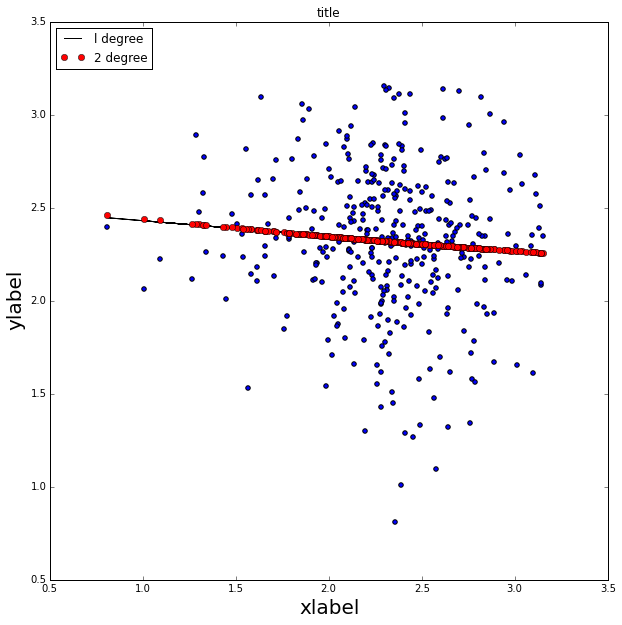

In [75]:
fig = pl.figure(figsize=(10,10))
pl.scatter(xlist, ylist)
plot(xlist, fit1.predict(), 'k', label="l degree")
plot(xlist, curve.predict(), 'ro', label="2 degree")
pl.title("title")
pl.xlabel("xlabel", fontsize=20)
pl.ylabel("ylabel", fontsize=20)
#pl.xlim(0,25000)
#pl.ylim(0,50)
pl.legend(loc=2)

In [76]:
# determine better model with loglikelihood ratio
lrt = -2*(fit1.llf - curve.llf)
lrt

0.011954242411889027

In [77]:
print fit1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.585
Date:                Thu, 19 Nov 2015   Prob (F-statistic):              0.109
Time:                        20:18:59   Log-Likelihood:                -179.76
No. Observations:                 372   AIC:                             363.5
Df Residuals:                     370   BIC:                             371.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.5140      0.122     20.616      0.0

In [78]:
# conducting Pearson's test
pearson = scipy.stats.pearsonr(xlist, ylist)
pearson_alpha = 0.05

r,p = pearson
def pearson_results(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results(r,p,pearson_alpha)

The Pearson r coefficient is -0.0833010305035. Is the 2-tailed p-value of 0.108706573381 smaller than 0.05?
Nope.
The correlation is not significant at the 0.05 alpha level.


In [327]:
#city_master.to_csv('city_master_out.csv')

electricity prod vs density?
two sample test = center vs outlying
multivariate test = center vs outlying vs city (csa)